# ITT9 (Bath-Diamond): deep learned sinogram dejittering and image denoising using TomoPhantom and TomoBAR packages
## Author: Jordan Taylor j.taylor2@bath.ac.uk

This challenge can be viewed like a supervised learning problem. That is, we want a model to train some input to map to a desired output. This means require lots of training input-target images.

In this notebook I have replicated the ITT9 challenge alongside other tasks. This notebook attempts to:

+ De-jitter images in sinogram space (as in ITT9)
+ Attempts to learn how to only de-noise images that need to (train with clean as well as noisy inputs)
+ De-noises images in reconstruction space

## Installation (conda environment):
* Install Tensorflow `conda install -c anaconda tensorflow-gpu` or `conda install -c anaconda tensorflow-cpu`
* Install TomoPhantom software https://github.com/dkazanc/TomoPhantom for modelling projection data and artifacts:
`conda install tomophantom -c ccpi`
* Install ASTRA Toolbox for reconstruction modules: `conda install -c astra-toolbox/label/dev astra-toolbox`
* Install TomoBAR a wrapper aeround ASTRA for iterative and direct reconstruction `conda install -c dkazanc tomobar`

## Imports

In [1]:
import tomophantom
from tomophantom.supp.artifacts import _Artifacts_
from   tomobar.methodsDIR              import RecToolsDIR
from   tomophantom import TomoP2D

# Keras has two different backends, this ensures it is tensorflow and not theano
from   tensorflow import keras
from   matplotlib import pyplot as plt

import numpy as np
import os

## Utility Function

In [2]:
def visualise(data, name = '', text = 'Learn to map {}\nto clean {}'):
    
    data    = {key : value.reshape(value.shape[:3]) for key, value in data.items()}
    fig, ax = plt.subplots(7, 4, figsize = (8, 12))

    for i, m in enumerate(range(14)):
        for j, key in enumerate('XY'):
            r, k = divmod(i, 2)
            c    = j + 2 * k
            ax[r, c].imshow(data[key][m], aspect = 1)
            ax[r, c].set_xticks([])
            ax[r, c].set_yticks([])

    for i, state in enumerate(['clean', 'jittered']):
        ax[0, 2 * i].set_title(text.format(state, name), x = 1.1)

    plt.show()

## Data Simulation

In [3]:
# Parameters
np.random.seed(0)
N_size     = 46
angles_num = 60
jitter     = 2

# Values to be used below
models     = np.arange(14) + 1
P          = int(np.sqrt(2) * N_size)
angles     = np.linspace(0.0, 179.9, angles_num, dtype = 'float32')
angles_rad = angles * (np.pi / 180)

path       = os.path.dirname(tomophantom.__file__)
path2Dlib  = os.path.join(path, "Phantom2DLibrary.dat")

FBP        = RecToolsDIR(DetectorsDimH = P,          # Horizontal detector dimension
                    DetectorsDimV = None,            # Vertical detector dimension (3D case)
                    CenterRotOffset = 0.0,           # Center of Rotation scalar
                    AnglesVec = angles_rad,          # A vector of projection angles in radians
                    ObjSize = N_size,                # Reconstructed object dimensions (scalar)
                    device_projector='cpu').FBP

# X is the input to our models and Y is the desired output
sinos  = {'X' : [], 'Y' : []}
recons = {'X' : [], 'Y' : []}

# forming dictionaries with artifact types
_noise_ =  {'noise_type' : 'Poisson',
        'noise_sigma' : 5000, # noise amplitude
        'noise_seed' : 0,
        'noise_prelog': True}

# misalignment dictionary
_sinoshifts_ = {'sinoshifts_maxamplitude' : jitter}

for model in models:
        
    # Initialise True phantom and sinogram
    phantom_2D = TomoP2D.Model(model, N_size, path2Dlib)
    sino_an    = TomoP2D.ModelSino(model, N_size, P, angles, path2Dlib)

    [[sino_an_, sino_misalign_raw], shifts] = _Artifacts_(sino_an, **_noise_, **_sinoshifts_)
    
    # Add both the truth and jittered sinograms as inputs to ensure
    # models can learn to only "fix if broken". Alternatively we could
    # easily build a classifier first and only input into models if
    # classifier detects the sinogram is noisy (this may be more effective)
    sinos['X']   += [sino_an, sino_an_]
    sinos['Y']   += [sino_an, sino_an]    
    
    # Use the Filtered Back Projection for reconstructions
    clean, noisy  = map(FBP, [sino_an, sino_an_])
    
    recons['X']  += [clean, noisy]
    recons['Y']  += [clean, clean]
    
# Convert lists to numpy arrays
for dictionary in [sinos, recons]:
    for key in dictionary:
        # Get numpy array versions of a list
        value           = np.array(dictionary[key])
        
        # Standardise it such that the difference between min and max is 1
        standard        = value / (np.max(value, axis = (1, 2)) - np.min(value, axis = (1, 2))).reshape(len(value), 1, 1)
        
        # Assign
        dictionary[key] = standard.reshape(*standard.shape, 1)

Sinogram shifts have been simulated.
Poisson noise have been added to the data.
Sinogram shifts have been simulated.
Poisson noise have been added to the data.
Sinogram shifts have been simulated.
Poisson noise have been added to the data.
Sinogram shifts have been simulated.
Poisson noise have been added to the data.
Sinogram shifts have been simulated.
Poisson noise have been added to the data.
Sinogram shifts have been simulated.
Poisson noise have been added to the data.
Sinogram shifts have been simulated.
Poisson noise have been added to the data.
Sinogram shifts have been simulated.
Poisson noise have been added to the data.
Sinogram shifts have been simulated.
Poisson noise have been added to the data.
Sinogram shifts have been simulated.
Poisson noise have been added to the data.
Sinogram shifts have been simulated.
Poisson noise have been added to the data.
Sinogram shifts have been simulated.
Poisson noise have been added to the data.
Sinogram shifts have been simulated.
Poi

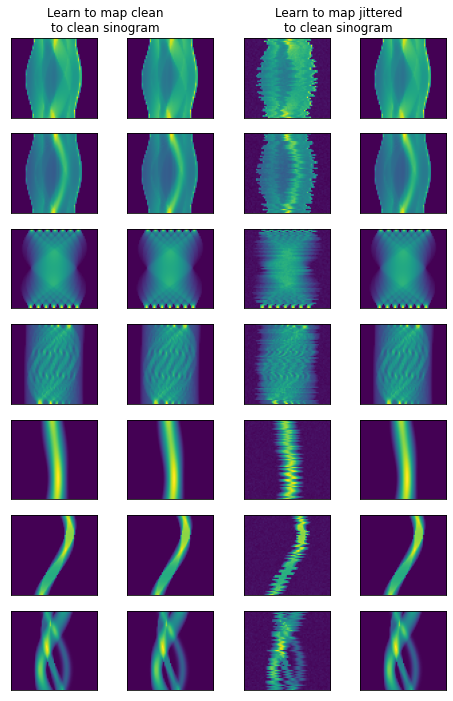

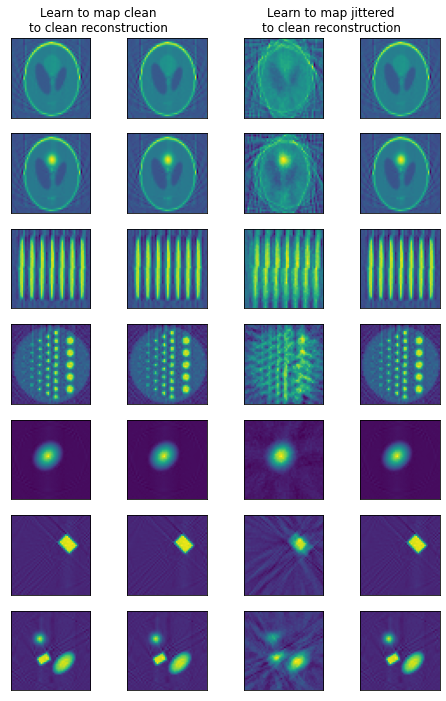

In [4]:
visualise(sinos , 'sinogram')
visualise(recons, 'reconstruction')

## Creating Neural Network Models
<br>

The two models this notebook focuses on are the De-Noising Auto-Encoder (DAE) and the Fully Connected Convolutions (FCC) Networks.

The main idea behind the Auto-Encoder (AE) is to perform some non-linear data driven principle component analysis for dimension reduction. By encapsulating what seems like a high dimensional object (the original image) we hope that it is now a more solvable problem in this lower dimensional latent space. This is what motivates the DAE (see [link](https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f) for more details).

If instead, you would like to keep your image in higher dimensions, this is feasible too (with the expense of more computations required). Though generally, the more complex the network, the more it is able to learn. This inspires the use of the FCC (not used during ITT9) as each layer of the network can have the same image dimensions.

## Loss Functions

The choice of which loss function is a tough choice to make. For regression tasks, the most popular loss functions are the Mean Squared Error (MSE) and the Mean Absolute Error (MAE). If we treat each pixel as some probability distribution, then we can also consider things like cross-entropy and Kullback-Leibler divergence. The model used at ITT9 was trained with the MSE loss function.

## Regularisation

The most popular form of regularisation in Neural Networks is the use of Dropout layers. Dropout is essentially an identity function whereby, with some probability you choose, features from the previous layer are ignored when computing the output. By doing this and updating gradients based on this, we encourage the magnitude of the weights of the network to be low. Similarly we can also take the $p$-norm of the weights as an additional constraint term to have a similar effect as dropout.

As discussed, at the ITT, perhaps we can use the Total Variation (TV) norm as a constraint as we desire an image with similar pixels next to each other.

## Methods Considered

1. **De-jitter in sinogram space** (as in ITT9)
2. **De-noise  in reconstruction space**

## Train & Evaluation of Models

In [5]:
# Define consistent optimizer for all models (not necessary)
# I tend to use Adam: https://arxiv.org/abs/1412.6980
# with the ams grad variant whilst slowly decaying the learning rate.
optimizer = keras.optimizers.Adam(1e-3, amsgrad = True, decay = 0.001)
loss      = 'mse'

### De-Noising Auto-Encoders

In [6]:
def create_DAE(input_shape, **kwargs):
    """Same model used in ITT9"""
    input_img  = keras.Input(shape = input_shape[1:])
    params     = {'activation' : 'relu', 'use_bias' : True}
    params.update(kwargs)
    
    # Encoding
    layer      = keras.layers.Conv2D(32, 3, **params)(input_img)
    layer      = keras.layers.MaxPool2D()(layer)
    layer      = keras.layers.Conv2D(32, 2, **params)(layer)
    layer      = keras.layers.MaxPool2D()(layer)
    
    # Fully Connected in latent space (optional)
    layer      = keras.layers.Flatten()(layer)
    layer      = keras.layers.Dense(6720, **params)(layer) # If N_size or angles_num changes, this will have to change
    layer      = keras.layers.Dropout(0.1)(layer)          # Optional Dropout layer
    layer      = keras.layers.Reshape((14, 15, 32))(layer) # Similarly, this has to change as well
    
    # Decoding
    layer      = keras.layers.Conv2DTranspose(8, 2, **params)(layer)
    layer      = keras.layers.UpSampling2D()(layer)
    layer      = keras.layers.Conv2DTranspose(8, 3, **params)(layer)
    layer      = keras.layers.UpSampling2D()(layer)
    
    # Output
    output_img = keras.layers.Conv2D(1, (5, 4), **params)(layer)
    return keras.Model(input_img, output_img)

In [7]:
def create_DAE2(input_shape, **kwargs):
    """Similar model to previous but now applied to reconstruction space"""
    input_img  = keras.Input(shape = input_shape[1:])
    params     = {'activation' : 'relu', 'use_bias' : True}
    params.update(kwargs)
    
    # Encoding
    layer      = keras.layers.Conv2D(32, 3, **params)(input_img)
    layer      = keras.layers.MaxPool2D()(layer)
    layer      = keras.layers.Conv2D(32, 2, **params)(layer)
    layer      = keras.layers.MaxPool2D()(layer)

    # Fully Connected in latent space (optional)
    layer      = keras.layers.Flatten()(layer)
    layer      = keras.layers.Dense(3200, **params)(layer) # These two lines will need to change
    layer      = keras.layers.Reshape((40, 40, 2))(layer)  # if N_size or angles_num changes
    
    # Decoding
    layer      = keras.layers.Conv2DTranspose(32, 3, **params)(layer)
    layer      = keras.layers.Conv2DTranspose(32, 3, **params)(layer)
    
    # Output
    output_img = keras.layers.Conv2DTranspose( 1, 3, **params)(layer)
    return keras.Model(input_img, output_img)

In [8]:
model1   = create_DAE(sinos['X'].shape)
model1.compile(optimizer = optimizer, loss = loss)
model1.fit(sinos['X'], sinos['Y'], epochs = 1000, verbose = 1)

Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1029
Epoch 2/1000
1/1 [==============================] - 0s 621us/step - loss: 0.0631
Epoch 3/1000
1/1 [==============================] - 0s 706us/step - loss: 0.0317
Epoch 4/1000
1/1 [==============================] - 0s 947us/step - loss: 0.0276
Epoch 5/1000
1/1 [==============================] - 0s 838us/step - loss: 0.0281
Epoch 6/1000
1/1 [==============================] - 0s 753us/step - loss: 0.0264
Epoch 7/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0235
Epoch 8/1000
1/1 [==============================] - 0s 646us/step - loss: 0.0217
Epoch 9/1000
1/1 [==============================] - 0s 578us/step - loss: 0.0208
Epoch 10/1000
1/1 [==============================] - 0s 771us/step - loss: 0.0196
Epoch 11/1000
1/1 [==============================] - 0s 634us/step - loss: 0.0184
Epoch 12/1000
1/1 [==============================] - 0s 524us/step - loss: 0.0176
Epoch 13/1000
1/1 [========

1/1 [==============================] - 0s 682us/step - loss: 0.0040
Epoch 102/1000
1/1 [==============================] - 0s 609us/step - loss: 0.0040
Epoch 103/1000
1/1 [==============================] - 0s 790us/step - loss: 0.0040
Epoch 104/1000
1/1 [==============================] - 0s 592us/step - loss: 0.0040
Epoch 105/1000
1/1 [==============================] - 0s 795us/step - loss: 0.0040
Epoch 106/1000
1/1 [==============================] - 0s 920us/step - loss: 0.0040
Epoch 107/1000
1/1 [==============================] - 0s 724us/step - loss: 0.0040
Epoch 108/1000
1/1 [==============================] - 0s 589us/step - loss: 0.0040
Epoch 109/1000
1/1 [==============================] - 0s 808us/step - loss: 0.0039
Epoch 110/1000
1/1 [==============================] - 0s 875us/step - loss: 0.0039
Epoch 111/1000
1/1 [==============================] - 0s 978us/step - loss: 0.0040
Epoch 112/1000
1/1 [==============================] - 0s 796us/step - loss: 0.0038
Epoch 113/1000
1/1 

1/1 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 201/1000
1/1 [==============================] - 0s 861us/step - loss: 0.0031
Epoch 202/1000
1/1 [==============================] - 0s 775us/step - loss: 0.0031
Epoch 203/1000
1/1 [==============================] - 0s 658us/step - loss: 0.0030
Epoch 204/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 205/1000
1/1 [==============================] - 0s 865us/step - loss: 0.0031
Epoch 206/1000
1/1 [==============================] - 0s 866us/step - loss: 0.0031
Epoch 207/1000
1/1 [==============================] - 0s 657us/step - loss: 0.0031
Epoch 208/1000
1/1 [==============================] - 0s 679us/step - loss: 0.0031
Epoch 209/1000
1/1 [==============================] - 0s 783us/step - loss: 0.0030
Epoch 210/1000
1/1 [==============================] - 0s 608us/step - loss: 0.0030
Epoch 211/1000
1/1 [==============================] - 0s 570us/step - loss: 0.0030
Epoch 212/1000
1/1 [===

1/1 [==============================] - 0s 643us/step - loss: 0.0027
Epoch 300/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 301/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 302/1000
1/1 [==============================] - 0s 935us/step - loss: 0.0028
Epoch 303/1000
1/1 [==============================] - 0s 638us/step - loss: 0.0027
Epoch 304/1000
1/1 [==============================] - 0s 800us/step - loss: 0.0028
Epoch 305/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 306/1000
1/1 [==============================] - 0s 641us/step - loss: 0.0027
Epoch 307/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 308/1000
1/1 [==============================] - 0s 685us/step - loss: 0.0027
Epoch 309/1000
1/1 [==============================] - 0s 603us/step - loss: 0.0027
Epoch 310/1000
1/1 [==============================] - 0s 715us/step - loss: 0.0026
Epoch 311/1000
1/1 [=======

1/1 [==============================] - 0s 778us/step - loss: 0.0025
Epoch 399/1000
1/1 [==============================] - 0s 600us/step - loss: 0.0024
Epoch 400/1000
1/1 [==============================] - 0s 662us/step - loss: 0.0025
Epoch 401/1000
1/1 [==============================] - 0s 605us/step - loss: 0.0025
Epoch 402/1000
1/1 [==============================] - 0s 613us/step - loss: 0.0025
Epoch 403/1000
1/1 [==============================] - 0s 650us/step - loss: 0.0025
Epoch 404/1000
1/1 [==============================] - 0s 675us/step - loss: 0.0026
Epoch 405/1000
1/1 [==============================] - 0s 628us/step - loss: 0.0025
Epoch 406/1000
1/1 [==============================] - 0s 620us/step - loss: 0.0025
Epoch 407/1000
1/1 [==============================] - 0s 822us/step - loss: 0.0024
Epoch 408/1000
1/1 [==============================] - 0s 906us/step - loss: 0.0025
Epoch 409/1000
1/1 [==============================] - 0s 739us/step - loss: 0.0025
Epoch 410/1000
1/1 

1/1 [==============================] - 0s 877us/step - loss: 0.0023
Epoch 498/1000
1/1 [==============================] - 0s 625us/step - loss: 0.0023
Epoch 499/1000
1/1 [==============================] - 0s 624us/step - loss: 0.0022
Epoch 500/1000
1/1 [==============================] - 0s 646us/step - loss: 0.0023
Epoch 501/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 502/1000
1/1 [==============================] - 0s 598us/step - loss: 0.0024
Epoch 503/1000
1/1 [==============================] - 0s 632us/step - loss: 0.0022
Epoch 504/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 505/1000
1/1 [==============================] - 0s 856us/step - loss: 0.0022
Epoch 506/1000
1/1 [==============================] - 0s 677us/step - loss: 0.0023
Epoch 507/1000
1/1 [==============================] - 0s 594us/step - loss: 0.0023
Epoch 508/1000
1/1 [==============================] - 0s 810us/step - loss: 0.0023
Epoch 509/1000
1/1 [===

1/1 [==============================] - 0s 729us/step - loss: 0.0021
Epoch 597/1000
1/1 [==============================] - 0s 893us/step - loss: 0.0021
Epoch 598/1000
1/1 [==============================] - 0s 633us/step - loss: 0.0022
Epoch 599/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 600/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 601/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 602/1000
1/1 [==============================] - 0s 642us/step - loss: 0.0022
Epoch 603/1000
1/1 [==============================] - 0s 704us/step - loss: 0.0021
Epoch 604/1000
1/1 [==============================] - 0s 815us/step - loss: 0.0022
Epoch 605/1000
1/1 [==============================] - 0s 614us/step - loss: 0.0021
Epoch 606/1000
1/1 [==============================] - 0s 595us/step - loss: 0.0022
Epoch 607/1000
1/1 [==============================] - 0s 563us/step - loss: 0.0022
Epoch 608/1000
1/1 [=====

1/1 [==============================] - 0s 653us/step - loss: 0.0020
Epoch 696/1000
1/1 [==============================] - 0s 570us/step - loss: 0.0020
Epoch 697/1000
1/1 [==============================] - 0s 658us/step - loss: 0.0021
Epoch 698/1000
1/1 [==============================] - 0s 719us/step - loss: 0.0021
Epoch 699/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 700/1000
1/1 [==============================] - 0s 617us/step - loss: 0.0019
Epoch 701/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 702/1000
1/1 [==============================] - 0s 692us/step - loss: 0.0020
Epoch 703/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 704/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 705/1000
1/1 [==============================] - 0s 600us/step - loss: 0.0020
Epoch 706/1000
1/1 [==============================] - 0s 646us/step - loss: 0.0019
Epoch 707/1000
1/1 [=======

1/1 [==============================] - 0s 589us/step - loss: 0.0019
Epoch 795/1000
1/1 [==============================] - 0s 721us/step - loss: 0.0019
Epoch 796/1000
1/1 [==============================] - 0s 795us/step - loss: 0.0020
Epoch 797/1000
1/1 [==============================] - 0s 667us/step - loss: 0.0020
Epoch 798/1000
1/1 [==============================] - 0s 758us/step - loss: 0.0019
Epoch 799/1000
1/1 [==============================] - 0s 955us/step - loss: 0.0020
Epoch 800/1000
1/1 [==============================] - 0s 640us/step - loss: 0.0019
Epoch 801/1000
1/1 [==============================] - 0s 749us/step - loss: 0.0019
Epoch 802/1000
1/1 [==============================] - 0s 706us/step - loss: 0.0019
Epoch 803/1000
1/1 [==============================] - 0s 879us/step - loss: 0.0020
Epoch 804/1000
1/1 [==============================] - 0s 597us/step - loss: 0.0019
Epoch 805/1000
1/1 [==============================] - 0s 609us/step - loss: 0.0019
Epoch 806/1000
1/1 

1/1 [==============================] - 0s 799us/step - loss: 0.0018
Epoch 894/1000
1/1 [==============================] - 0s 625us/step - loss: 0.0019
Epoch 895/1000
1/1 [==============================] - 0s 610us/step - loss: 0.0018
Epoch 896/1000
1/1 [==============================] - 0s 594us/step - loss: 0.0019
Epoch 897/1000
1/1 [==============================] - 0s 805us/step - loss: 0.0019
Epoch 898/1000
1/1 [==============================] - 0s 622us/step - loss: 0.0019
Epoch 899/1000
1/1 [==============================] - 0s 581us/step - loss: 0.0019
Epoch 900/1000
1/1 [==============================] - 0s 698us/step - loss: 0.0018
Epoch 901/1000
1/1 [==============================] - 0s 598us/step - loss: 0.0019
Epoch 902/1000
1/1 [==============================] - 0s 873us/step - loss: 0.0018
Epoch 903/1000
1/1 [==============================] - 0s 602us/step - loss: 0.0019
Epoch 904/1000
1/1 [==============================] - 0s 595us/step - loss: 0.0019
Epoch 905/1000
1/1 

1/1 [==============================] - 0s 608us/step - loss: 0.0018
Epoch 993/1000
1/1 [==============================] - 0s 679us/step - loss: 0.0018
Epoch 994/1000
1/1 [==============================] - 0s 683us/step - loss: 0.0018
Epoch 995/1000
1/1 [==============================] - 0s 646us/step - loss: 0.0018
Epoch 996/1000
1/1 [==============================] - 0s 608us/step - loss: 0.0018
Epoch 997/1000
1/1 [==============================] - 0s 692us/step - loss: 0.0018
Epoch 998/1000
1/1 [==============================] - 0s 605us/step - loss: 0.0018
Epoch 999/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 1000/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018


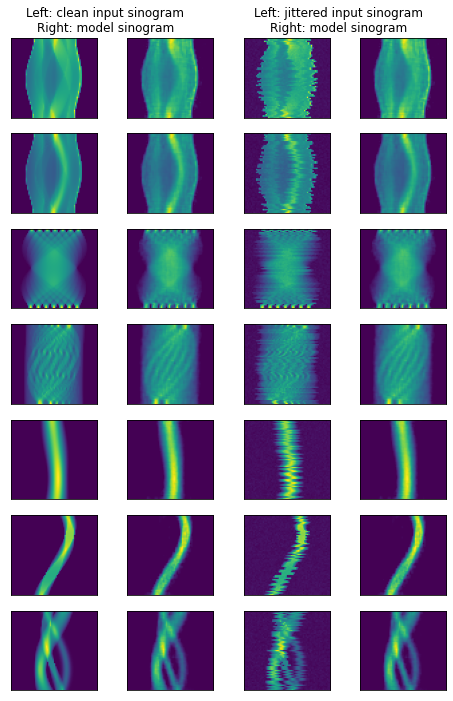

In [9]:
visualise({'X' : sinos['X'], 'Y' : model1.predict(sinos['X'])}, text = 'Left: {} input sinogram\nRight: model sinogram')

In [10]:
model2   = create_DAE2(recons['X'].shape)
model2.compile(optimizer = optimizer, loss = loss)
model2.fit(recons['X'], recons['Y'], epochs = 1000, verbose = 1)

Epoch 1/1000
1/1 [==============================] - 0s 793us/step - loss: 0.0782
Epoch 2/1000
1/1 [==============================] - 0s 705us/step - loss: 0.0706
Epoch 3/1000
1/1 [==============================] - 0s 796us/step - loss: 0.0503
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0317
Epoch 5/1000
1/1 [==============================] - 0s 780us/step - loss: 0.0556
Epoch 6/1000
1/1 [==============================] - 0s 606us/step - loss: 0.0276
Epoch 7/1000
1/1 [==============================] - 0s 741us/step - loss: 0.0320
Epoch 8/1000
1/1 [==============================] - 0s 577us/step - loss: 0.0378
Epoch 9/1000
1/1 [==============================] - 0s 616us/step - loss: 0.0386
Epoch 10/1000
1/1 [==============================] - 0s 879us/step - loss: 0.0354
Epoch 11/1000
1/1 [==============================] - 0s 681us/step - loss: 0.0301
Epoch 12/1000
1/1 [==============================] - 0s 648us/step - loss: 0.0256
Epoch 13/1000
1/1 [========

Epoch 101/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 102/1000
1/1 [==============================] - 0s 762us/step - loss: 0.0038
Epoch 103/1000
1/1 [==============================] - 0s 788us/step - loss: 0.0038
Epoch 104/1000
1/1 [==============================] - 0s 653us/step - loss: 0.0038
Epoch 105/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 106/1000
1/1 [==============================] - 0s 614us/step - loss: 0.0037
Epoch 107/1000
1/1 [==============================] - 0s 684us/step - loss: 0.0037
Epoch 108/1000
1/1 [==============================] - 0s 961us/step - loss: 0.0037
Epoch 109/1000
1/1 [==============================] - 0s 644us/step - loss: 0.0037
Epoch 110/1000
1/1 [==============================] - 0s 853us/step - loss: 0.0037
Epoch 111/1000
1/1 [==============================] - 0s 713us/step - loss: 0.0037
Epoch 112/1000
1/1 [==============================] - 0s 587us/step - loss: 0.0037
Epoch 11

1/1 [==============================] - 0s 830us/step - loss: 0.0031
Epoch 201/1000
1/1 [==============================] - 0s 865us/step - loss: 0.0031
Epoch 202/1000
1/1 [==============================] - 0s 797us/step - loss: 0.0031
Epoch 203/1000
1/1 [==============================] - 0s 600us/step - loss: 0.0031
Epoch 204/1000
1/1 [==============================] - 0s 601us/step - loss: 0.0030
Epoch 205/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 206/1000
1/1 [==============================] - 0s 587us/step - loss: 0.0030
Epoch 207/1000
1/1 [==============================] - 0s 613us/step - loss: 0.0030
Epoch 208/1000
1/1 [==============================] - 0s 575us/step - loss: 0.0030
Epoch 209/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 210/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 211/1000
1/1 [==============================] - 0s 702us/step - loss: 0.0030
Epoch 212/1000
1/1 [=====

1/1 [==============================] - 0s 650us/step - loss: 0.0025
Epoch 300/1000
1/1 [==============================] - 0s 564us/step - loss: 0.0025
Epoch 301/1000
1/1 [==============================] - 0s 662us/step - loss: 0.0025
Epoch 302/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 303/1000
1/1 [==============================] - 0s 609us/step - loss: 0.0025
Epoch 304/1000
1/1 [==============================] - ETA: 0s - loss: 0.002 - 0s 791us/step - loss: 0.0025
Epoch 305/1000
1/1 [==============================] - 0s 584us/step - loss: 0.0025
Epoch 306/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0025
Epoch 307/1000
1/1 [==============================] - 0s 782us/step - loss: 0.0025
Epoch 308/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 309/1000
1/1 [==============================] - 0s 569us/step - loss: 0.0025
Epoch 310/1000
1/1 [==============================] - 0s 564us/step - loss: 0.0025

Epoch 398/1000
1/1 [==============================] - 0s 565us/step - loss: 0.0022
Epoch 399/1000
1/1 [==============================] - 0s 808us/step - loss: 0.0022
Epoch 400/1000
1/1 [==============================] - 0s 641us/step - loss: 0.0022
Epoch 401/1000
1/1 [==============================] - 0s 655us/step - loss: 0.0022
Epoch 402/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 403/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 404/1000
1/1 [==============================] - 0s 661us/step - loss: 0.0022
Epoch 405/1000
1/1 [==============================] - 0s 739us/step - loss: 0.0022
Epoch 406/1000
1/1 [==============================] - 0s 550us/step - loss: 0.0022
Epoch 407/1000
1/1 [==============================] - 0s 578us/step - loss: 0.0022
Epoch 408/1000
1/1 [==============================] - 0s 601us/step - loss: 0.0022
Epoch 409/1000
1/1 [==============================] - 0s 627us/step - loss: 0.0022
Epoch 41

1/1 [==============================] - 0s 548us/step - loss: 0.0020
Epoch 498/1000
1/1 [==============================] - 0s 971us/step - loss: 0.0020
Epoch 499/1000
1/1 [==============================] - 0s 652us/step - loss: 0.0020
Epoch 500/1000
1/1 [==============================] - 0s 624us/step - loss: 0.0020
Epoch 501/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 502/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 503/1000
1/1 [==============================] - 0s 651us/step - loss: 0.0020
Epoch 504/1000
1/1 [==============================] - 0s 666us/step - loss: 0.0020
Epoch 505/1000
1/1 [==============================] - 0s 592us/step - loss: 0.0020
Epoch 506/1000
1/1 [==============================] - 0s 737us/step - loss: 0.0020
Epoch 507/1000
1/1 [==============================] - 0s 953us/step - loss: 0.0020
Epoch 508/1000
1/1 [==============================] - 0s 609us/step - loss: 0.0020
Epoch 509/1000
1/1 [===

1/1 [==============================] - 0s 834us/step - loss: 0.0019
Epoch 597/1000
1/1 [==============================] - 0s 643us/step - loss: 0.0019
Epoch 598/1000
1/1 [==============================] - 0s 756us/step - loss: 0.0019
Epoch 599/1000
1/1 [==============================] - 0s 699us/step - loss: 0.0019
Epoch 600/1000
1/1 [==============================] - 0s 651us/step - loss: 0.0019
Epoch 601/1000
1/1 [==============================] - 0s 741us/step - loss: 0.0019
Epoch 602/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 603/1000
1/1 [==============================] - 0s 569us/step - loss: 0.0019
Epoch 604/1000
1/1 [==============================] - 0s 628us/step - loss: 0.0019
Epoch 605/1000
1/1 [==============================] - 0s 655us/step - loss: 0.0019
Epoch 606/1000
1/1 [==============================] - 0s 597us/step - loss: 0.0019
Epoch 607/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 608/1000
1/1 [===

1/1 [==============================] - 0s 841us/step - loss: 0.0017
Epoch 696/1000
1/1 [==============================] - 0s 820us/step - loss: 0.0017
Epoch 697/1000
1/1 [==============================] - 0s 710us/step - loss: 0.0017
Epoch 698/1000
1/1 [==============================] - 0s 704us/step - loss: 0.0017
Epoch 699/1000
1/1 [==============================] - 0s 605us/step - loss: 0.0017
Epoch 700/1000
1/1 [==============================] - 0s 635us/step - loss: 0.0017
Epoch 701/1000
1/1 [==============================] - 0s 820us/step - loss: 0.0017
Epoch 702/1000
1/1 [==============================] - 0s 583us/step - loss: 0.0017
Epoch 703/1000
1/1 [==============================] - 0s 761us/step - loss: 0.0017
Epoch 704/1000
1/1 [==============================] - 0s 664us/step - loss: 0.0017
Epoch 705/1000
1/1 [==============================] - 0s 548us/step - loss: 0.0017
Epoch 706/1000
1/1 [==============================] - 0s 668us/step - loss: 0.0017
Epoch 707/1000
1/1 

1/1 [==============================] - 0s 924us/step - loss: 0.0017
Epoch 795/1000
1/1 [==============================] - 0s 689us/step - loss: 0.0017
Epoch 796/1000
1/1 [==============================] - 0s 750us/step - loss: 0.0017
Epoch 797/1000
1/1 [==============================] - 0s 639us/step - loss: 0.0017
Epoch 798/1000
1/1 [==============================] - 0s 647us/step - loss: 0.0017
Epoch 799/1000
1/1 [==============================] - 0s 802us/step - loss: 0.0017
Epoch 800/1000
1/1 [==============================] - 0s 745us/step - loss: 0.0016
Epoch 801/1000
1/1 [==============================] - 0s 660us/step - loss: 0.0016
Epoch 802/1000
1/1 [==============================] - 0s 609us/step - loss: 0.0016
Epoch 803/1000
1/1 [==============================] - 0s 588us/step - loss: 0.0016
Epoch 804/1000
1/1 [==============================] - 0s 634us/step - loss: 0.0016
Epoch 805/1000
1/1 [==============================] - 0s 620us/step - loss: 0.0016
Epoch 806/1000
1/1 

1/1 [==============================] - 0s 606us/step - loss: 0.0016
Epoch 894/1000
1/1 [==============================] - 0s 736us/step - loss: 0.0016
Epoch 895/1000
1/1 [==============================] - 0s 575us/step - loss: 0.0016
Epoch 896/1000
1/1 [==============================] - 0s 616us/step - loss: 0.0016
Epoch 897/1000
1/1 [==============================] - 0s 880us/step - loss: 0.0016
Epoch 898/1000
1/1 [==============================] - 0s 826us/step - loss: 0.0016
Epoch 899/1000
1/1 [==============================] - 0s 608us/step - loss: 0.0016
Epoch 900/1000
1/1 [==============================] - 0s 714us/step - loss: 0.0016
Epoch 901/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 902/1000
1/1 [==============================] - 0s 630us/step - loss: 0.0016
Epoch 903/1000
1/1 [==============================] - 0s 882us/step - loss: 0.0016
Epoch 904/1000
1/1 [==============================] - ETA: 0s - loss: 0.001 - 0s 757us/step - loss: 0.00

1/1 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 993/1000
1/1 [==============================] - 0s 646us/step - loss: 0.0015
Epoch 994/1000
1/1 [==============================] - 0s 622us/step - loss: 0.0015
Epoch 995/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 996/1000
1/1 [==============================] - 0s 592us/step - loss: 0.0015
Epoch 997/1000
1/1 [==============================] - 0s 796us/step - loss: 0.0015
Epoch 998/1000
1/1 [==============================] - 0s 578us/step - loss: 0.0015
Epoch 999/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 1000/1000
1/1 [==============================] - 0s 626us/step - loss: 0.0015


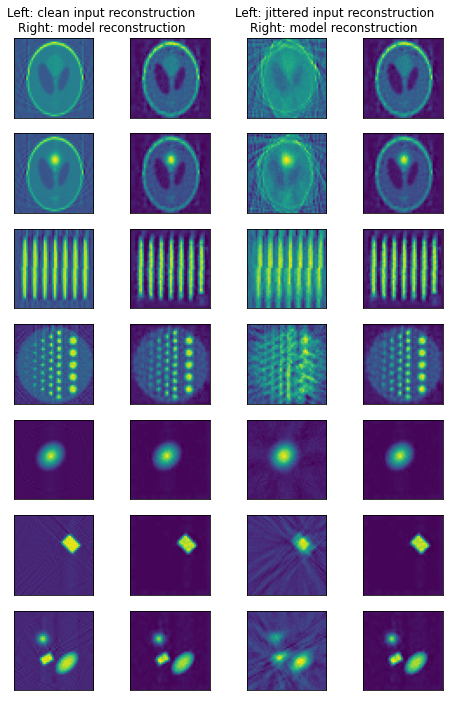

In [11]:
visualise({'X' : recons['X'], 'Y' : model2.predict(recons['X'])},
          text = 'Left: {} input reconstruction\nRight: model reconstruction')

### Fully Connected Convolutions

In [12]:
def create_FCC(input_shape, **kwargs):
    """Similar model to previous but now image dimensions remains constant"""
    input_img  = keras.Input(shape = input_shape[1:])
    params     = {'activation' : 'relu', 'padding' : 'same', 'use_bias' : True}
    params.update(kwargs)

    layer      = keras.layers.Conv2D( 32, 3, **params)(input_img)
    layer      = keras.layers.Conv2D( 64, 2, **params)(layer)
    layer      = keras.layers.Conv2D(128, 2, **params)(layer)
    layer      = keras.layers.Conv2D( 32, 2, **params)(layer)
    output_img = keras.layers.Conv2D(  1, 2, **params)(layer)
    
    return keras.Model(input_img, output_img)    

In [13]:
def create_FCC2(input_shape, **kwargs):
    """Similar model to previous but with additional layers"""
    input_img  = keras.Input(shape = input_shape[1:])
    params     = {'activation' : 'relu', 'padding' : 'same', 'use_bias' : True}
    params.update(kwargs)

    layer      = keras.layers.Conv2D( 16, 3, **params)(input_img)
    layer      = keras.layers.Conv2D( 32, 3, **params)(layer)
    layer      = keras.layers.Conv2D( 64, 3, **params)(layer)
    layer      = keras.layers.Conv2D(128, 3, **params)(layer)
    layer      = keras.layers.Conv2D(256, 3, **params)(layer)
    layer      = keras.layers.Conv2D( 64, 3, **params)(layer)
    layer      = keras.layers.Conv2D( 16, 3, **params)(layer)
    output_img = keras.layers.Conv2D(  1, 2, **params)(layer)
    
    return keras.Model(input_img, output_img)    

In [14]:
model3   = create_FCC(sinos['X'].shape)
model3.compile(optimizer = optimizer, loss = loss)
model3.fit(sinos['X'], sinos['Y'], epochs = 1000, verbose = 1)

Epoch 1/1000
28/28 [==============================] - 3s 100ms/step - loss: 3.6954
Epoch 2/1000
28/28 [==============================] - 2s 81ms/step - loss: 2.9324
Epoch 3/1000
28/28 [==============================] - 2s 82ms/step - loss: 1.8026
Epoch 4/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.7121
Epoch 5/1000
28/28 [==============================] - 2s 80ms/step - loss: 0.7518
Epoch 6/1000
28/28 [==============================] - 2s 87ms/step - loss: 1.2309
Epoch 7/1000
28/28 [==============================] - 3s 93ms/step - loss: 0.7224
Epoch 8/1000
28/28 [==============================] - 3s 94ms/step - loss: 0.3963
Epoch 9/1000
28/28 [==============================] - 3s 94ms/step - loss: 0.4952
Epoch 10/1000
28/28 [==============================] - 3s 94ms/step - loss: 0.6110
Epoch 11/1000
28/28 [==============================] - 3s 93ms/step - loss: 0.5461
Epoch 12/1000
28/28 [==============================] - 3s 93ms/step - loss: 0.3645
Epoch 13/100

Epoch 100/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0348
Epoch 101/1000
28/28 [==============================] - 2s 82ms/step - loss: 0.0347
Epoch 102/1000
28/28 [==============================] - 2s 80ms/step - loss: 0.0346
Epoch 103/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0345
Epoch 104/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0344
Epoch 105/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0343
Epoch 106/1000
28/28 [==============================] - 2s 82ms/step - loss: 0.0342
Epoch 107/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0341
Epoch 108/1000
28/28 [==============================] - 2s 86ms/step - loss: 0.0340
Epoch 109/1000
28/28 [==============================] - 3s 94ms/step - loss: 0.0339
Epoch 110/1000
28/28 [==============================] - 3s 95ms/step - loss: 0.0338
Epoch 111/1000
28/28 [==============================] - 3s 92ms/step - loss:

Epoch 198/1000
28/28 [==============================] - 2s 82ms/step - loss: 0.0288
Epoch 199/1000
28/28 [==============================] - 2s 80ms/step - loss: 0.0288
Epoch 200/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0288
Epoch 201/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0287
Epoch 202/1000
28/28 [==============================] - 2s 82ms/step - loss: 0.0287
Epoch 203/1000
28/28 [==============================] - 2s 80ms/step - loss: 0.0286
Epoch 204/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0286
Epoch 205/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0285
Epoch 206/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0285
Epoch 207/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0285
Epoch 208/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0284
Epoch 209/1000
28/28 [==============================] - 2s 82ms/step - loss:

Epoch 296/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0254
Epoch 297/1000
28/28 [==============================] - 2s 82ms/step - loss: 0.0254
Epoch 298/1000
28/28 [==============================] - 2s 80ms/step - loss: 0.0253
Epoch 299/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0253
Epoch 300/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0253
Epoch 301/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0253
Epoch 302/1000
28/28 [==============================] - 2s 86ms/step - loss: 0.0252
Epoch 303/1000
28/28 [==============================] - 2s 83ms/step - loss: 0.0252
Epoch 304/1000
28/28 [==============================] - 3s 90ms/step - loss: 0.0252
Epoch 305/1000
28/28 [==============================] - 3s 97ms/step - loss: 0.0252
Epoch 306/1000
28/28 [==============================] - 3s 94ms/step - loss: 0.0251
Epoch 307/1000
28/28 [==============================] - 3s 97ms/step - loss:

Epoch 394/1000
28/28 [==============================] - 2s 87ms/step - loss: 0.0229
Epoch 395/1000
28/28 [==============================] - 2s 82ms/step - loss: 0.0229
Epoch 396/1000
28/28 [==============================] - 2s 80ms/step - loss: 0.0228
Epoch 397/1000
28/28 [==============================] - 2s 80ms/step - loss: 0.0228
Epoch 398/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0228
Epoch 399/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0228
Epoch 400/1000
28/28 [==============================] - 2s 84ms/step - loss: 0.0227
Epoch 401/1000
28/28 [==============================] - 2s 86ms/step - loss: 0.0227
Epoch 402/1000
28/28 [==============================] - 2s 83ms/step - loss: 0.0227
Epoch 403/1000
28/28 [==============================] - 3s 94ms/step - loss: 0.0227
Epoch 404/1000
28/28 [==============================] - 3s 99ms/step - loss: 0.0227
Epoch 405/1000
28/28 [==============================] - 3s 94ms/step - loss:

Epoch 492/1000
28/28 [==============================] - 3s 95ms/step - loss: 0.0210
Epoch 493/1000
28/28 [==============================] - 3s 95ms/step - loss: 0.0210
Epoch 494/1000
28/28 [==============================] - 3s 97ms/step - loss: 0.0210
Epoch 495/1000
28/28 [==============================] - 2s 89ms/step - loss: 0.0210
Epoch 496/1000
28/28 [==============================] - 3s 103ms/step - loss: 0.0210
Epoch 497/1000
28/28 [==============================] - 3s 91ms/step - loss: 0.0210
Epoch 498/1000
28/28 [==============================] - 2s 87ms/step - loss: 0.0210
Epoch 499/1000
28/28 [==============================] - 2s 83ms/step - loss: 0.0209
Epoch 500/1000
28/28 [==============================] - 3s 90ms/step - loss: 0.0209
Epoch 501/1000
28/28 [==============================] - 3s 93ms/step - loss: 0.0209
Epoch 502/1000
28/28 [==============================] - 3s 96ms/step - loss: 0.0210
Epoch 503/1000
28/28 [==============================] - 3s 93ms/step - loss

Epoch 590/1000
28/28 [==============================] - 2s 82ms/step - loss: 0.0198
Epoch 591/1000
28/28 [==============================] - 2s 82ms/step - loss: 0.0197
Epoch 592/1000
28/28 [==============================] - 2s 83ms/step - loss: 0.0197
Epoch 593/1000
28/28 [==============================] - 2s 85ms/step - loss: 0.0197
Epoch 594/1000
28/28 [==============================] - 2s 84ms/step - loss: 0.0197
Epoch 595/1000
28/28 [==============================] - 2s 86ms/step - loss: 0.0197
Epoch 596/1000
28/28 [==============================] - 2s 83ms/step - loss: 0.0197
Epoch 597/1000
28/28 [==============================] - 2s 88ms/step - loss: 0.0197
Epoch 598/1000
28/28 [==============================] - 2s 86ms/step - loss: 0.0197
Epoch 599/1000
28/28 [==============================] - 2s 83ms/step - loss: 0.0196
Epoch 600/1000
28/28 [==============================] - 2s 80ms/step - loss: 0.0196
Epoch 601/1000
28/28 [==============================] - 2s 81ms/step - loss:

Epoch 688/1000
28/28 [==============================] - 3s 90ms/step - loss: 0.0187
Epoch 689/1000
28/28 [==============================] - 2s 83ms/step - loss: 0.0187
Epoch 690/1000
28/28 [==============================] - 2s 80ms/step - loss: 0.0187
Epoch 691/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0187
Epoch 692/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0187
Epoch 693/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0187
Epoch 694/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0187
Epoch 695/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0187
Epoch 696/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0187
Epoch 697/1000
28/28 [==============================] - 2s 88ms/step - loss: 0.0186
Epoch 698/1000
28/28 [==============================] - 3s 94ms/step - loss: 0.0186
Epoch 699/1000
28/28 [==============================] - 3s 95ms/step - loss:

Epoch 786/1000
28/28 [==============================] - 3s 91ms/step - loss: 0.0179
Epoch 787/1000
28/28 [==============================] - 2s 86ms/step - loss: 0.0179
Epoch 788/1000
28/28 [==============================] - 2s 83ms/step - loss: 0.0178
Epoch 789/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0178
Epoch 790/1000
28/28 [==============================] - 2s 84ms/step - loss: 0.0178
Epoch 791/1000
28/28 [==============================] - 2s 86ms/step - loss: 0.0178
Epoch 792/1000
28/28 [==============================] - 2s 82ms/step - loss: 0.0178
Epoch 793/1000
28/28 [==============================] - 2s 83ms/step - loss: 0.0178
Epoch 794/1000
28/28 [==============================] - 2s 82ms/step - loss: 0.0178
Epoch 795/1000
28/28 [==============================] - 3s 90ms/step - loss: 0.0178
Epoch 796/1000
28/28 [==============================] - 3s 94ms/step - loss: 0.0178
Epoch 797/1000
28/28 [==============================] - 3s 95ms/step - loss:

Epoch 884/1000
28/28 [==============================] - 3s 95ms/step - loss: 0.0171
Epoch 885/1000
28/28 [==============================] - 3s 93ms/step - loss: 0.0171
Epoch 886/1000
28/28 [==============================] - 2s 86ms/step - loss: 0.0171
Epoch 887/1000
28/28 [==============================] - 2s 83ms/step - loss: 0.0171
Epoch 888/1000
28/28 [==============================] - 2s 83ms/step - loss: 0.0171
Epoch 889/1000
28/28 [==============================] - 2s 88ms/step - loss: 0.0171
Epoch 890/1000
28/28 [==============================] - 2s 84ms/step - loss: 0.0171
Epoch 891/1000
28/28 [==============================] - 2s 85ms/step - loss: 0.0171
Epoch 892/1000
28/28 [==============================] - 2s 88ms/step - loss: 0.0171
Epoch 893/1000
28/28 [==============================] - 3s 100ms/step - loss: 0.0171
Epoch 894/1000
28/28 [==============================] - 3s 99ms/step - loss: 0.0171
Epoch 895/1000
28/28 [==============================] - 3s 99ms/step - loss

Epoch 982/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0165
Epoch 983/1000
28/28 [==============================] - 2s 85ms/step - loss: 0.0165
Epoch 984/1000
28/28 [==============================] - 2s 86ms/step - loss: 0.0165
Epoch 985/1000
28/28 [==============================] - 2s 83ms/step - loss: 0.0165
Epoch 986/1000
28/28 [==============================] - 2s 81ms/step - loss: 0.0165
Epoch 987/1000
28/28 [==============================] - 2s 86ms/step - loss: 0.0165
Epoch 988/1000
28/28 [==============================] - 2s 86ms/step - loss: 0.0165
Epoch 989/1000
28/28 [==============================] - 2s 84ms/step - loss: 0.0165
Epoch 990/1000
28/28 [==============================] - 2s 86ms/step - loss: 0.0164
Epoch 991/1000
28/28 [==============================] - 2s 82ms/step - loss: 0.0164
Epoch 992/1000
28/28 [==============================] - 3s 96ms/step - loss: 0.0164
Epoch 993/1000
28/28 [==============================] - 3s 95ms/step - loss:

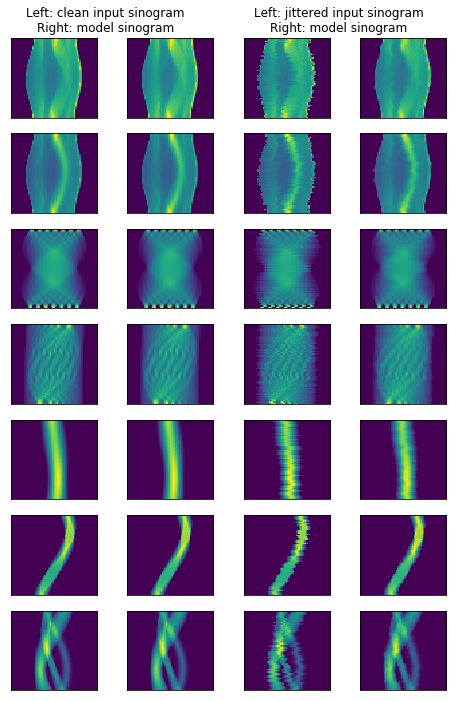

In [15]:
visualise({'X' : sinos['X'], 'Y' :model3.predict(sinos['X'])}, text = 'Left: {} input sinogram\nRight: model sinogram')

In [16]:
model4   = create_FCC2(sinos['X'].shape)
model4.compile(optimizer = optimizer, loss = loss)
model4.fit(sinos['X'], sinos['Y'], epochs = 1000, verbose = 1)

Epoch 1/1000
28/28 [==============================] - 16s 554ms/step - loss: 3.5788
Epoch 2/1000
28/28 [==============================] - 14s 517ms/step - loss: 1.5490
Epoch 3/1000
28/28 [==============================] - 15s 520ms/step - loss: 3.1475
Epoch 4/1000
28/28 [==============================] - 17s 595ms/step - loss: 0.4436
Epoch 5/1000
28/28 [==============================] - 15s 534ms/step - loss: 1.4857
Epoch 6/1000
28/28 [==============================] - 15s 520ms/step - loss: 1.9039
Epoch 7/1000
28/28 [==============================] - 17s 600ms/step - loss: 1.8592
Epoch 8/1000
28/28 [==============================] - 15s 525ms/step - loss: 1.4761
Epoch 9/1000
28/28 [==============================] - 15s 522ms/step - loss: 0.8133
Epoch 10/1000
28/28 [==============================] - 15s 531ms/step - loss: 0.2336
Epoch 11/1000
28/28 [==============================] - 14s 514ms/step - loss: 0.9020
Epoch 12/1000
28/28 [==============================] - 18s 637ms/step - lo

Epoch 98/1000
28/28 [==============================] - 15s 533ms/step - loss: 0.0268
Epoch 99/1000
28/28 [==============================] - 14s 514ms/step - loss: 0.0266
Epoch 100/1000
28/28 [==============================] - 14s 509ms/step - loss: 0.0263
Epoch 101/1000
28/28 [==============================] - 16s 563ms/step - loss: 0.0260
Epoch 102/1000
28/28 [==============================] - 16s 581ms/step - loss: 0.0257
Epoch 103/1000
28/28 [==============================] - 15s 522ms/step - loss: 0.0255
Epoch 104/1000
28/28 [==============================] - 14s 507ms/step - loss: 0.0252
Epoch 105/1000
28/28 [==============================] - 14s 514ms/step - loss: 0.0250
Epoch 106/1000
28/28 [==============================] - 14s 511ms/step - loss: 0.0249
Epoch 107/1000
28/28 [==============================] - 14s 510ms/step - loss: 0.0248
Epoch 108/1000
28/28 [==============================] - 14s 508ms/step - loss: 0.0249
Epoch 109/1000
28/28 [==============================] - 

Epoch 194/1000
28/28 [==============================] - 16s 556ms/step - loss: 0.0168
Epoch 195/1000
28/28 [==============================] - 14s 506ms/step - loss: 0.0167
Epoch 196/1000
28/28 [==============================] - 16s 589ms/step - loss: 0.0167
Epoch 197/1000
28/28 [==============================] - 16s 574ms/step - loss: 0.0167
Epoch 198/1000
28/28 [==============================] - 15s 531ms/step - loss: 0.0166
Epoch 199/1000
28/28 [==============================] - 16s 560ms/step - loss: 0.0166
Epoch 200/1000
28/28 [==============================] - 15s 527ms/step - loss: 0.0165
Epoch 201/1000
28/28 [==============================] - 15s 532ms/step - loss: 0.0164
Epoch 202/1000
28/28 [==============================] - 14s 515ms/step - loss: 0.0163
Epoch 203/1000
28/28 [==============================] - 14s 509ms/step - loss: 0.0163
Epoch 204/1000
28/28 [==============================] - 16s 577ms/step - loss: 0.0163
Epoch 205/1000
28/28 [==============================] 

Epoch 290/1000
28/28 [==============================] - 14s 508ms/step - loss: 0.0140
Epoch 291/1000
28/28 [==============================] - 14s 509ms/step - loss: 0.0140
Epoch 292/1000
28/28 [==============================] - 14s 505ms/step - loss: 0.0140
Epoch 293/1000
28/28 [==============================] - 14s 514ms/step - loss: 0.0139
Epoch 294/1000
28/28 [==============================] - 17s 603ms/step - loss: 0.0139
Epoch 295/1000
28/28 [==============================] - 14s 510ms/step - loss: 0.0139
Epoch 296/1000
28/28 [==============================] - 14s 511ms/step - loss: 0.0139
Epoch 297/1000
28/28 [==============================] - 14s 506ms/step - loss: 0.0139
Epoch 298/1000
28/28 [==============================] - 14s 506ms/step - loss: 0.0139
Epoch 299/1000
28/28 [==============================] - 15s 521ms/step - loss: 0.0139
Epoch 300/1000
28/28 [==============================] - 14s 508ms/step - loss: 0.0139
Epoch 301/1000
28/28 [==============================] 

Epoch 386/1000
28/28 [==============================] - 15s 531ms/step - loss: 0.0127
Epoch 387/1000
28/28 [==============================] - 15s 521ms/step - loss: 0.0127
Epoch 388/1000
28/28 [==============================] - 16s 576ms/step - loss: 0.0126
Epoch 389/1000
28/28 [==============================] - 14s 501ms/step - loss: 0.0126
Epoch 390/1000
28/28 [==============================] - 15s 546ms/step - loss: 0.0126
Epoch 391/1000
28/28 [==============================] - 16s 570ms/step - loss: 0.0126
Epoch 392/1000
28/28 [==============================] - 14s 513ms/step - loss: 0.0126
Epoch 393/1000
28/28 [==============================] - 14s 511ms/step - loss: 0.0126
Epoch 394/1000
28/28 [==============================] - 14s 512ms/step - loss: 0.0126
Epoch 395/1000
28/28 [==============================] - 15s 523ms/step - loss: 0.0125
Epoch 396/1000
28/28 [==============================] - 15s 538ms/step - loss: 0.0125
Epoch 397/1000
28/28 [==============================] 

Epoch 482/1000
28/28 [==============================] - 17s 607ms/step - loss: 0.0117
Epoch 483/1000
28/28 [==============================] - 16s 580ms/step - loss: 0.0117
Epoch 484/1000
28/28 [==============================] - 15s 545ms/step - loss: 0.0117
Epoch 485/1000
28/28 [==============================] - 17s 612ms/step - loss: 0.0117
Epoch 486/1000
28/28 [==============================] - 15s 538ms/step - loss: 0.0116
Epoch 487/1000
28/28 [==============================] - 15s 532ms/step - loss: 0.0116
Epoch 488/1000
28/28 [==============================] - 15s 526ms/step - loss: 0.0116
Epoch 489/1000
28/28 [==============================] - 15s 526ms/step - loss: 0.0116
Epoch 490/1000
28/28 [==============================] - 19s 671ms/step - loss: 0.0116
Epoch 491/1000
28/28 [==============================] - 15s 544ms/step - loss: 0.0116
Epoch 492/1000
28/28 [==============================] - 16s 580ms/step - loss: 0.0116
Epoch 493/1000
28/28 [==============================] 

Epoch 578/1000
28/28 [==============================] - 15s 522ms/step - loss: 0.0109
Epoch 579/1000
28/28 [==============================] - 15s 522ms/step - loss: 0.0109
Epoch 580/1000
28/28 [==============================] - 15s 525ms/step - loss: 0.0109
Epoch 581/1000
28/28 [==============================] - 16s 575ms/step - loss: 0.0109
Epoch 582/1000
28/28 [==============================] - 15s 548ms/step - loss: 0.0109
Epoch 583/1000
28/28 [==============================] - 15s 528ms/step - loss: 0.0109
Epoch 584/1000
28/28 [==============================] - 14s 508ms/step - loss: 0.0109
Epoch 585/1000
28/28 [==============================] - 14s 505ms/step - loss: 0.0109
Epoch 586/1000
28/28 [==============================] - 14s 505ms/step - loss: 0.0109
Epoch 587/1000
28/28 [==============================] - 14s 507ms/step - loss: 0.0109
Epoch 588/1000
28/28 [==============================] - 14s 506ms/step - loss: 0.0109
Epoch 589/1000
28/28 [==============================] 

Epoch 674/1000
28/28 [==============================] - 14s 504ms/step - loss: 0.0103
Epoch 675/1000
28/28 [==============================] - 14s 507ms/step - loss: 0.0103
Epoch 676/1000
28/28 [==============================] - 14s 504ms/step - loss: 0.0103
Epoch 677/1000
28/28 [==============================] - 14s 508ms/step - loss: 0.0103
Epoch 678/1000
28/28 [==============================] - 14s 507ms/step - loss: 0.0103
Epoch 679/1000
28/28 [==============================] - 15s 521ms/step - loss: 0.0103
Epoch 680/1000
28/28 [==============================] - 17s 609ms/step - loss: 0.0103
Epoch 681/1000
28/28 [==============================] - 14s 516ms/step - loss: 0.0103
Epoch 682/1000
28/28 [==============================] - 14s 509ms/step - loss: 0.0103
Epoch 683/1000
28/28 [==============================] - 14s 508ms/step - loss: 0.0103
Epoch 684/1000
28/28 [==============================] - 15s 519ms/step - loss: 0.0103
Epoch 685/1000
28/28 [==============================] 

Epoch 770/1000
28/28 [==============================] - 16s 567ms/step - loss: 0.0098
Epoch 771/1000
28/28 [==============================] - 15s 543ms/step - loss: 0.0098
Epoch 772/1000
28/28 [==============================] - 14s 507ms/step - loss: 0.0098
Epoch 773/1000
28/28 [==============================] - 14s 507ms/step - loss: 0.0098
Epoch 774/1000
28/28 [==============================] - 14s 509ms/step - loss: 0.0098
Epoch 775/1000
28/28 [==============================] - 14s 507ms/step - loss: 0.0097
Epoch 776/1000
28/28 [==============================] - 14s 510ms/step - loss: 0.0097
Epoch 777/1000
28/28 [==============================] - 14s 510ms/step - loss: 0.0097
Epoch 778/1000
28/28 [==============================] - 16s 554ms/step - loss: 0.0097
Epoch 779/1000
28/28 [==============================] - 16s 565ms/step - loss: 0.0097
Epoch 780/1000
28/28 [==============================] - 14s 513ms/step - loss: 0.0097
Epoch 781/1000
28/28 [==============================] 

Epoch 866/1000
28/28 [==============================] - 15s 529ms/step - loss: 0.0093
Epoch 867/1000
28/28 [==============================] - 14s 507ms/step - loss: 0.0093
Epoch 868/1000
28/28 [==============================] - 14s 504ms/step - loss: 0.0093
Epoch 869/1000
28/28 [==============================] - 16s 584ms/step - loss: 0.0093
Epoch 870/1000
28/28 [==============================] - 15s 531ms/step - loss: 0.0093
Epoch 871/1000
28/28 [==============================] - 14s 506ms/step - loss: 0.0093
Epoch 872/1000
28/28 [==============================] - 14s 506ms/step - loss: 0.0093
Epoch 873/1000
28/28 [==============================] - 14s 506ms/step - loss: 0.0093
Epoch 874/1000
28/28 [==============================] - 14s 505ms/step - loss: 0.0093
Epoch 875/1000
28/28 [==============================] - 14s 506ms/step - loss: 0.0093
Epoch 876/1000
28/28 [==============================] - 14s 504ms/step - loss: 0.0093
Epoch 877/1000
28/28 [==============================] 

Epoch 962/1000
28/28 [==============================] - 14s 506ms/step - loss: 0.0089
Epoch 963/1000
28/28 [==============================] - 14s 508ms/step - loss: 0.0089
Epoch 964/1000
28/28 [==============================] - 14s 509ms/step - loss: 0.0089
Epoch 965/1000
28/28 [==============================] - 14s 506ms/step - loss: 0.0089
Epoch 966/1000
28/28 [==============================] - 14s 506ms/step - loss: 0.0089
Epoch 967/1000
28/28 [==============================] - 14s 507ms/step - loss: 0.0089
Epoch 968/1000
28/28 [==============================] - 17s 593ms/step - loss: 0.0089
Epoch 969/1000
28/28 [==============================] - 15s 541ms/step - loss: 0.0089
Epoch 970/1000
28/28 [==============================] - 14s 510ms/step - loss: 0.0089
Epoch 971/1000
28/28 [==============================] - 14s 508ms/step - loss: 0.0089
Epoch 972/1000
28/28 [==============================] - 14s 507ms/step - loss: 0.0089
Epoch 973/1000
28/28 [==============================] 

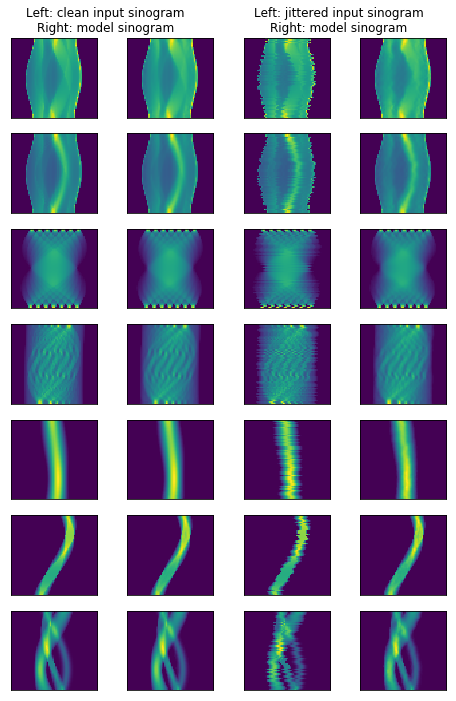

In [17]:
visualise({'X' : sinos['X'], 'Y' :model4.predict(sinos['X'])}, text = 'Left: {} input sinogram\nRight: model sinogram')

In [18]:
model5   = create_FCC(recons['X'].shape)
model5.compile(optimizer = optimizer, loss = loss)
model5.fit(recons['X'], recons['Y'], epochs = 1000, verbose = 1)

Epoch 1/1000
28/28 [==============================] - 2s 79ms/step - loss: 1.2717
Epoch 2/1000
28/28 [==============================] - 1s 47ms/step - loss: 1.0949
Epoch 3/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.8752
Epoch 4/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.7253
Epoch 5/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.7252
Epoch 6/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.7277
Epoch 7/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.6400
Epoch 8/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.5491
Epoch 9/1000
28/28 [==============================] - 1s 46ms/step - loss: 0.5072
Epoch 10/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.4923
Epoch 11/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.4459
Epoch 12/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.3670
Epoch 13/1000

Epoch 100/1000
28/28 [==============================] - 2s 59ms/step - loss: 0.1101
Epoch 101/1000
28/28 [==============================] - 2s 58ms/step - loss: 0.1101
Epoch 102/1000
28/28 [==============================] - 1s 51ms/step - loss: 0.1100
Epoch 103/1000
28/28 [==============================] - 1s 50ms/step - loss: 0.1099
Epoch 104/1000
28/28 [==============================] - 1s 46ms/step - loss: 0.1098
Epoch 105/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.1098
Epoch 106/1000
28/28 [==============================] - 1s 46ms/step - loss: 0.1097
Epoch 107/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.1096
Epoch 108/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.1095
Epoch 109/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.1094
Epoch 110/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.1094
Epoch 111/1000
28/28 [==============================] - 1s 45ms/step - loss:

Epoch 198/1000
28/28 [==============================] - 1s 46ms/step - loss: 0.1033
Epoch 199/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.1033
Epoch 200/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.1032
Epoch 201/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.1031
Epoch 202/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.1031
Epoch 203/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.1030
Epoch 204/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.1029
Epoch 205/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.1028
Epoch 206/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.1028
Epoch 207/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.1027
Epoch 208/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.1026
Epoch 209/1000
28/28 [==============================] - 1s 45ms/step - loss:

Epoch 296/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0972
Epoch 297/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0972
Epoch 298/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0971
Epoch 299/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0971
Epoch 300/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0970
Epoch 301/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0969
Epoch 302/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0969
Epoch 303/1000
28/28 [==============================] - 1s 46ms/step - loss: 0.0968
Epoch 304/1000
28/28 [==============================] - 1s 47ms/step - loss: 0.0968
Epoch 305/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0967
Epoch 306/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0967
Epoch 307/1000
28/28 [==============================] - 1s 44ms/step - loss:

Epoch 394/1000
28/28 [==============================] - 1s 46ms/step - loss: 0.0925
Epoch 395/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0925
Epoch 396/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0924
Epoch 397/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0924
Epoch 398/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0924
Epoch 399/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0923
Epoch 400/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0923
Epoch 401/1000
28/28 [==============================] - 1s 48ms/step - loss: 0.0922
Epoch 402/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0922
Epoch 403/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0921
Epoch 404/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0921
Epoch 405/1000
28/28 [==============================] - 1s 45ms/step - loss:

Epoch 492/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0888
Epoch 493/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0887
Epoch 494/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0887
Epoch 495/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0887
Epoch 496/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0886
Epoch 497/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0886
Epoch 498/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0886
Epoch 499/1000
28/28 [==============================] - 1s 46ms/step - loss: 0.0885
Epoch 500/1000
28/28 [==============================] - 1s 46ms/step - loss: 0.0885
Epoch 501/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0885
Epoch 502/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0884
Epoch 503/1000
28/28 [==============================] - 1s 44ms/step - loss:

Epoch 590/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0859
Epoch 591/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0859
Epoch 592/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0859
Epoch 593/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0858
Epoch 594/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0858
Epoch 595/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0858
Epoch 596/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0858
Epoch 597/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0857
Epoch 598/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0857
Epoch 599/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0857
Epoch 600/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0856
Epoch 601/1000
28/28 [==============================] - 1s 45ms/step - loss:

Epoch 688/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0835
Epoch 689/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0835
Epoch 690/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0835
Epoch 691/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0835
Epoch 692/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0834
Epoch 693/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0834
Epoch 694/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0834
Epoch 695/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0834
Epoch 696/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0833
Epoch 697/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0833
Epoch 698/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0833
Epoch 699/1000
28/28 [==============================] - 1s 44ms/step - loss:

Epoch 786/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0815
Epoch 787/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0815
Epoch 788/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0815
Epoch 789/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0814
Epoch 790/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0814
Epoch 791/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0814
Epoch 792/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0814
Epoch 793/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0814
Epoch 794/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0813
Epoch 795/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0813
Epoch 796/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0813
Epoch 797/1000
28/28 [==============================] - 1s 44ms/step - loss:

Epoch 884/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0798
Epoch 885/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0798
Epoch 886/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0797
Epoch 887/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0797
Epoch 888/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0797
Epoch 889/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0797
Epoch 890/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0797
Epoch 891/1000
28/28 [==============================] - 1s 46ms/step - loss: 0.0797
Epoch 892/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0797
Epoch 893/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0797
Epoch 894/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0796
Epoch 895/1000
28/28 [==============================] - 1s 44ms/step - loss:

Epoch 982/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0783
Epoch 983/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0783
Epoch 984/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0783
Epoch 985/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0783
Epoch 986/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0783
Epoch 987/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0783
Epoch 988/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0783
Epoch 989/1000
28/28 [==============================] - 1s 44ms/step - loss: 0.0783
Epoch 990/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0782
Epoch 991/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0782
Epoch 992/1000
28/28 [==============================] - 1s 45ms/step - loss: 0.0782
Epoch 993/1000
28/28 [==============================] - 1s 44ms/step - loss:

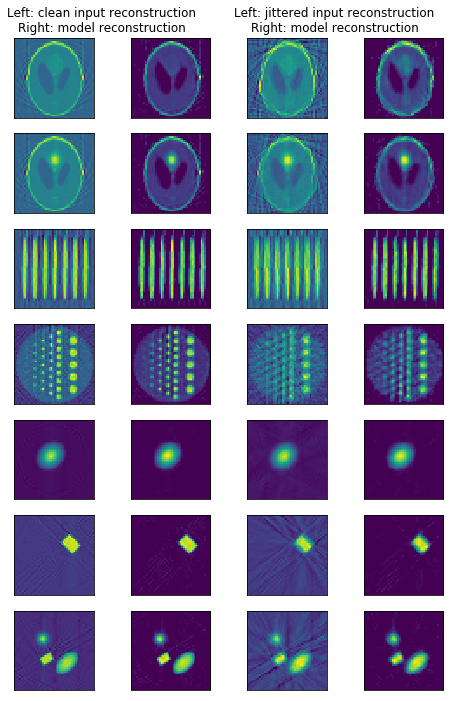

In [19]:
visualise({'X' : recons['X'], 'Y' :model5.predict(recons['X'])},
          text = 'Left: {} input reconstruction\nRight: model reconstruction')

In [20]:
model6   = create_FCC2(recons['X'].shape)
model6.compile(optimizer = optimizer, loss = loss)
model6.fit(recons['X'], recons['Y'], epochs = 1000, verbose = 1)

Epoch 1/1000
28/28 [==============================] - 9s 315ms/step - loss: 1.2918
Epoch 2/1000
28/28 [==============================] - 8s 278ms/step - loss: 1.1540
Epoch 3/1000
28/28 [==============================] - 10s 357ms/step - loss: 0.7701
Epoch 4/1000
28/28 [==============================] - 11s 385ms/step - loss: 0.6024
Epoch 5/1000
28/28 [==============================] - 8s 290ms/step - loss: 0.4650
Epoch 6/1000
28/28 [==============================] - 8s 278ms/step - loss: 0.4278
Epoch 7/1000
28/28 [==============================] - 8s 280ms/step - loss: 0.3606
Epoch 8/1000
28/28 [==============================] - 8s 279ms/step - loss: 0.2772
Epoch 9/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.2716
Epoch 10/1000
28/28 [==============================] - 8s 282ms/step - loss: 0.2295
Epoch 11/1000
28/28 [==============================] - 8s 288ms/step - loss: 0.2173
Epoch 12/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.2028

Epoch 99/1000
28/28 [==============================] - 8s 278ms/step - loss: 0.0972
Epoch 100/1000
28/28 [==============================] - 8s 279ms/step - loss: 0.0969
Epoch 101/1000
28/28 [==============================] - 8s 283ms/step - loss: 0.0966
Epoch 102/1000
28/28 [==============================] - 8s 276ms/step - loss: 0.0963
Epoch 103/1000
28/28 [==============================] - 8s 279ms/step - loss: 0.0960
Epoch 104/1000
28/28 [==============================] - 8s 276ms/step - loss: 0.0958
Epoch 105/1000
28/28 [==============================] - 8s 276ms/step - loss: 0.0955
Epoch 106/1000
28/28 [==============================] - 8s 283ms/step - loss: 0.0952
Epoch 107/1000
28/28 [==============================] - 8s 291ms/step - loss: 0.0949
Epoch 108/1000
28/28 [==============================] - 9s 327ms/step - loss: 0.0946
Epoch 109/1000
28/28 [==============================] - 9s 310ms/step - loss: 0.0943
Epoch 110/1000
28/28 [==============================] - 8s 280ms/s

Epoch 196/1000
28/28 [==============================] - 8s 302ms/step - loss: 0.0782
Epoch 197/1000
28/28 [==============================] - 10s 360ms/step - loss: 0.0781
Epoch 198/1000
28/28 [==============================] - 9s 324ms/step - loss: 0.0780
Epoch 199/1000
28/28 [==============================] - 8s 300ms/step - loss: 0.0780
Epoch 200/1000
28/28 [==============================] - 8s 289ms/step - loss: 0.0779
Epoch 201/1000
28/28 [==============================] - 8s 285ms/step - loss: 0.0777
Epoch 202/1000
28/28 [==============================] - 8s 284ms/step - loss: 0.0774
Epoch 203/1000
28/28 [==============================] - 8s 287ms/step - loss: 0.0772
Epoch 204/1000
28/28 [==============================] - 8s 283ms/step - loss: 0.0771
Epoch 205/1000
28/28 [==============================] - 8s 284ms/step - loss: 0.0770
Epoch 206/1000
28/28 [==============================] - 8s 284ms/step - loss: 0.0770
Epoch 207/1000
28/28 [==============================] - 8s 283ms

Epoch 293/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0673
Epoch 294/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0673
Epoch 295/1000
28/28 [==============================] - 8s 279ms/step - loss: 0.0672
Epoch 296/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0670
Epoch 297/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0668
Epoch 298/1000
28/28 [==============================] - 8s 278ms/step - loss: 0.0666
Epoch 299/1000
28/28 [==============================] - 9s 317ms/step - loss: 0.0665
Epoch 300/1000
28/28 [==============================] - 9s 327ms/step - loss: 0.0665
Epoch 301/1000
28/28 [==============================] - 8s 298ms/step - loss: 0.0665
Epoch 302/1000
28/28 [==============================] - 8s 280ms/step - loss: 0.0664
Epoch 303/1000
28/28 [==============================] - 8s 281ms/step - loss: 0.0664
Epoch 304/1000
28/28 [==============================] - 8s 280ms/

Epoch 390/1000
28/28 [==============================] - 9s 328ms/step - loss: 0.0598
Epoch 391/1000
28/28 [==============================] - 8s 286ms/step - loss: 0.0598
Epoch 392/1000
28/28 [==============================] - 8s 280ms/step - loss: 0.0597
Epoch 393/1000
28/28 [==============================] - 8s 282ms/step - loss: 0.0597
Epoch 394/1000
28/28 [==============================] - 8s 276ms/step - loss: 0.0597
Epoch 395/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0598
Epoch 396/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0598
Epoch 397/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0598
Epoch 398/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0598
Epoch 399/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0597
Epoch 400/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0595
Epoch 401/1000
28/28 [==============================] - 8s 278ms/

Epoch 487/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0551
Epoch 488/1000
28/28 [==============================] - 8s 295ms/step - loss: 0.0551
Epoch 489/1000
28/28 [==============================] - 8s 278ms/step - loss: 0.0552
Epoch 490/1000
28/28 [==============================] - 8s 278ms/step - loss: 0.0552
Epoch 491/1000
28/28 [==============================] - 8s 278ms/step - loss: 0.0552
Epoch 492/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0551
Epoch 493/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0550
Epoch 494/1000
28/28 [==============================] - 9s 326ms/step - loss: 0.0548
Epoch 495/1000
28/28 [==============================] - 9s 324ms/step - loss: 0.0546
Epoch 496/1000
28/28 [==============================] - 8s 279ms/step - loss: 0.0545
Epoch 497/1000
28/28 [==============================] - 8s 280ms/step - loss: 0.0544
Epoch 498/1000
28/28 [==============================] - 8s 280ms/

Epoch 584/1000
28/28 [==============================] - 9s 319ms/step - loss: 0.0513
Epoch 585/1000
28/28 [==============================] - 9s 327ms/step - loss: 0.0514
Epoch 586/1000
28/28 [==============================] - 9s 313ms/step - loss: 0.0514
Epoch 587/1000
28/28 [==============================] - 8s 283ms/step - loss: 0.0514
Epoch 588/1000
28/28 [==============================] - 8s 284ms/step - loss: 0.0514
Epoch 589/1000
28/28 [==============================] - 8s 285ms/step - loss: 0.0513
Epoch 590/1000
28/28 [==============================] - 8s 278ms/step - loss: 0.0512
Epoch 591/1000
28/28 [==============================] - 8s 279ms/step - loss: 0.0511
Epoch 592/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0510
Epoch 593/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0510
Epoch 594/1000
28/28 [==============================] - 8s 276ms/step - loss: 0.0509
Epoch 595/1000
28/28 [==============================] - 8s 279ms/

Epoch 681/1000
28/28 [==============================] - 8s 280ms/step - loss: 0.0484
Epoch 682/1000
28/28 [==============================] - 8s 278ms/step - loss: 0.0484
Epoch 683/1000
28/28 [==============================] - 8s 280ms/step - loss: 0.0484
Epoch 684/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0484
Epoch 685/1000
28/28 [==============================] - 8s 278ms/step - loss: 0.0484
Epoch 686/1000
28/28 [==============================] - 8s 278ms/step - loss: 0.0484
Epoch 687/1000
28/28 [==============================] - 8s 295ms/step - loss: 0.0485
Epoch 688/1000
28/28 [==============================] - 9s 330ms/step - loss: 0.0484
Epoch 689/1000
28/28 [==============================] - 9s 311ms/step - loss: 0.0484
Epoch 690/1000
28/28 [==============================] - 8s 279ms/step - loss: 0.0483
Epoch 691/1000
28/28 [==============================] - 8s 284ms/step - loss: 0.0482
Epoch 692/1000
28/28 [==============================] - 8s 285ms/

Epoch 778/1000
28/28 [==============================] - 9s 328ms/step - loss: 0.0461
Epoch 779/1000
28/28 [==============================] - 8s 284ms/step - loss: 0.0461
Epoch 780/1000
28/28 [==============================] - 8s 282ms/step - loss: 0.0461
Epoch 781/1000
28/28 [==============================] - 8s 280ms/step - loss: 0.0461
Epoch 782/1000
28/28 [==============================] - 8s 281ms/step - loss: 0.0461
Epoch 783/1000
28/28 [==============================] - 8s 281ms/step - loss: 0.0461
Epoch 784/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0461
Epoch 785/1000
28/28 [==============================] - 8s 276ms/step - loss: 0.0461
Epoch 786/1000
28/28 [==============================] - 8s 294ms/step - loss: 0.0460
Epoch 787/1000
28/28 [==============================] - 8s 279ms/step - loss: 0.0460
Epoch 788/1000
28/28 [==============================] - 8s 279ms/step - loss: 0.0460
Epoch 789/1000
28/28 [==============================] - 8s 278ms/

Epoch 875/1000
28/28 [==============================] - 8s 279ms/step - loss: 0.0444
Epoch 876/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0443
Epoch 877/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0443
Epoch 878/1000
28/28 [==============================] - 8s 278ms/step - loss: 0.0442
Epoch 879/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0442
Epoch 880/1000
28/28 [==============================] - 8s 277ms/step - loss: 0.0441
Epoch 881/1000
28/28 [==============================] - 8s 278ms/step - loss: 0.0440
Epoch 882/1000
28/28 [==============================] - 9s 322ms/step - loss: 0.0440
Epoch 883/1000
28/28 [==============================] - 9s 326ms/step - loss: 0.0440
Epoch 884/1000
28/28 [==============================] - 9s 308ms/step - loss: 0.0440
Epoch 885/1000
28/28 [==============================] - 8s 284ms/step - loss: 0.0439
Epoch 886/1000
28/28 [==============================] - 8s 280ms/

Epoch 972/1000
28/28 [==============================] - 9s 328ms/step - loss: 0.0429
Epoch 973/1000
28/28 [==============================] - 9s 330ms/step - loss: 0.0428
Epoch 974/1000
28/28 [==============================] - 8s 283ms/step - loss: 0.0427
Epoch 975/1000
28/28 [==============================] - 8s 279ms/step - loss: 0.0426
Epoch 976/1000
28/28 [==============================] - 8s 279ms/step - loss: 0.0425
Epoch 977/1000
28/28 [==============================] - 8s 281ms/step - loss: 0.0424
Epoch 978/1000
28/28 [==============================] - 8s 278ms/step - loss: 0.0424
Epoch 979/1000
28/28 [==============================] - 8s 278ms/step - loss: 0.0424
Epoch 980/1000
28/28 [==============================] - 8s 279ms/step - loss: 0.0425
Epoch 981/1000
28/28 [==============================] - 8s 280ms/step - loss: 0.0425
Epoch 982/1000
28/28 [==============================] - 8s 279ms/step - loss: 0.0425
Epoch 983/1000
28/28 [==============================] - 8s 278ms/

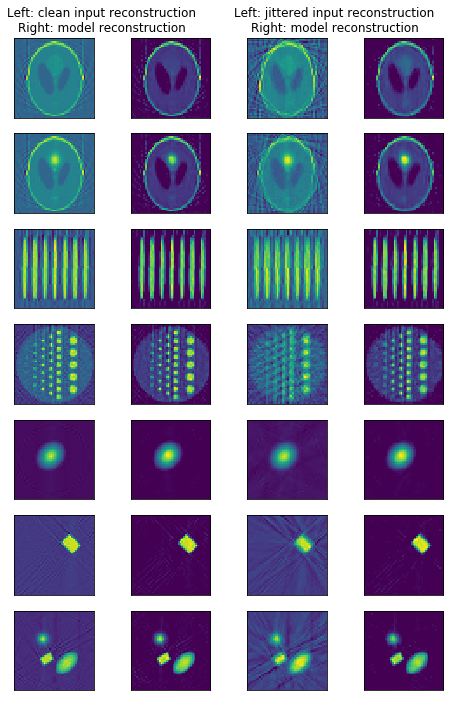

In [21]:
visualise({'X' : recons['X'], 'Y' :model6.predict(recons['X'])},
          text = 'Left: {} input reconstruction\nRight: model reconstruction')

## Future Works

### Variational De-Noising Auto-Encoder (VDAE)

Instead of encoding to some latent space $z$ directly, the VDAE outputs distribution parameters for a distribution you choose. For example, if you choose a multivariate $\mathcal{N}(\mu, \Sigma | \text{image})$, we may wish the encoder to output $\mu$ and $\sigma$ where $\sigma^{\text{T}}\sigma = \Sigma$ such that we can draw $z$. As the encoder and decoder are deterministic functions with $z$ the only random part, we can quantify the uncertainty with the VDAE by calculating the the pdf of the normal at $z$.

[D.P. Kingma & M. Welling: Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)

### Conditional Generative Adversiarial Networks (CGAN)

A Generative Adversarial Network (GAN) uses two neural networks to train each other. The first network, the generator, attempts to generate data similar to the ones present in out training dataset whilst the other network, the discriminator is a binary classifying network attempting to say which data belongs to the real dataset and which data was generated. Though, the original GAN will just generate any suitable image which is not appropriate for our problem. This is where the CGAN comes in, where we can give a rough image as the prior and it can generate proposal images, again, with uncertainty quantification.

[I.J. Goodfellow et al: Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)<br>
[M. Mirza & S. Osindero: Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)